# Insper - Ciência dos Dados 2022.2

## Engenharia - 2ºB

### Integrantes do grupo:

* Beatriz Rodrigues de Freitas

* Carlos Eduardo Porciuncula Yamada

* Verônica Luisa Ribeiro Lima

___
<div id='sumario'></div>

## Sumário

1. [Introdução](#intro)

2. [Minerando Dados e Características do Dataset](#data-mining)

3. [Modelos de Predição](#prediction)

4. [Processo e Estatísticas de Validação](#validation)

5. [Conclusão](#conclusion)

6. [Referências Bibliográficas](#ref)

___
<div id='intro'></div>

## 1. Introdução

### Objetivo

O objetivo deste projeto é criar um código capaz de prever o preço de um notebook (em euros) a partir de algumas features fornescidas pela base de dados "Laptop_price", disponibilizada na plataforma Kaggle por MUHAMMET VARLI em 2020. 
Os dados utilizados para a modelagem da target estão descritos a seguir:


### Descrição da base de dados

* `Company`: **object** → Fabricante do computador;

* `TypeName`: **object** → Tipo do uso;

* `Inches`: **float** → Tamanho (em polegadas);

* `Cpu`: **object** → Qual o processador;

* `Ram`: **object** → Quantidade de memória Ram;

* `Memory`: **object** → Quantidade de memória Rom, assim como o seu tipo;

* `Product`: **object** → Modelo do notebook;

* `ScreenResolution`: **object** → Resolução da tela;

* `OpSys`: **object** → Sistema operacional.


As bibliotecas utilizadas na contrução do robô serão as seguintes:

In [24]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
import os
import re 
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
laptop_price = pd.read_csv('dados/laptop_price.csv',sep=',',  encoding='latin-1')
laptop_price.head(3)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00


___
<div id='data-mining'></div>

## 2. Minerando Dados e Características do Dataset




O primeiro passo foi identificar quais seriam as features que modelam o preço. Para tal, foi utilizado o **groupby** e o **describe** para ver a relação de cada coluna com o valor do notebook, como se observa no arquivo **Describes**. 
Juntando esses resultados com o conhecimento prévio acerca de quais componentes mais influenciam no preço de um computador, foi decidido não levar em consideração a resulução da tela, o peso e o sistema operacinal.

Um problema das features CPU, Memory e GPU é a grande quantidade de opções: 118, 39 e 110, respectivamente, o que pode interferir na eficiência do código.
Não seria viável reagrupar as Gpu's, pois há uma grande variação de preço dentro de uma mesma categoria (uma Nvidia GeForce GTX 500 custa menos da metade de uma Nvidia GeForce GTX 1650, por exemplo) - o mesmo ocorre com "Memory", pois 256GB em SSD é mais caro do que a mesma quantidade em um HD. Assim, a única feature que pode ter as categorias resumidas sem maiores perdas seria o processador. Para tal, observou-se quais os mais recorrentes:

In [26]:
laptop_price['Cpu'].value_counts()

Intel Core i5 7200U 2.5GHz       190
Intel Core i7 7700HQ 2.8GHz      146
Intel Core i7 7500U 2.7GHz       134
Intel Core i7 8550U 1.8GHz        73
Intel Core i5 8250U 1.6GHz        72
                                ... 
Intel Core M M3-6Y30 0.9GHz        1
AMD A9-Series 9420 2.9GHz          1
Intel Core i3 6006U 2.2GHz         1
AMD A6-Series 7310 2GHz            1
Intel Xeon E3-1535M v6 3.1GHz      1
Name: Cpu, Length: 118, dtype: int64

A partir dessa contagem, as Cpu's foram separadas nas seguintes categorias, seguindo a recorrência: Intel Core I7, Intel Core I5, Intel Core I3, Intel Pentium, Intel Celeron, AMD e outros.

In [27]:
dados = laptop_price.loc[:, ['Company', 'TypeName', 'Cpu', "Inches", 'Ram', 'Memory', 'Gpu', 'Price_euros']]

dados.insert(3, 'Processor', '')  # --> onde será armazenado as novas categorias de processador

tamanho = len(dados['Company'])

for i in range(0, tamanho):
    cpu = dados["Cpu"][i]

    if re.search("AMD", cpu):
        dados.loc[i,'Processor']= 'AMD'
    elif re.search("Intel Pentium", cpu):
        dados.loc[i,'Processor']= 'Intel Pentium'
    elif re.search("Intel Core i3", cpu):
        dados.loc[i,'Processor']= 'Intel Core i3'
    elif re.search("Intel Core i5", cpu):
        dados.loc[i,'Processor']= 'Intel Core i5'
    elif re.search("Intel Core i7", cpu):
        dados.loc[i,'Processor']= 'Intel Core i7'
    elif re.search("Intel Celeron", cpu):
        dados.loc[i,'Processor']= 'Intel Celeron'
    else:
        dados.loc[i,'Processor']= 'Outros'

dados.drop(columns = 'Cpu', axis = 1, inplace=True)
dados.head(3)

,Company,TypeName,Processor,Inches,Ram,Memory,Gpu,Price_euros
0,Apple,Ultrabook,Intel Core i5,13.3,8GB,128GB SSD,Intel Iris Plus Graphics 640,1339.69
1,Apple,Ultrabook,Intel Core i5,13.3,8GB,128GB Flash Storage,Intel HD Graphics 6000,898.94
2,HP,Notebook,Intel Core i5,15.6,8GB,256GB SSD,Intel HD Graphics 620,575.00


[Voltar para o sumário](#sumario)


## 2.1 Análise exploratória


### 2.1 Disposição dos preços

Entendendo como o preço varia na base de dados

In [28]:
dados['Price_euros'].describe()

count    1303.000000
mean     1123.686992
std       699.009043
min       174.000000
25%       599.000000
50%       977.000000
75%      1487.880000
max      6099.000000
Name: Price_euros, dtype: float64

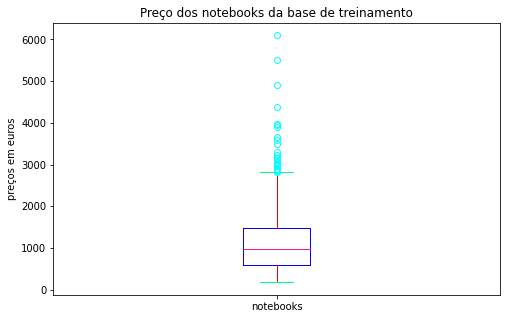

In [29]:
plt.figure(figsize=(8,5))

plt.subplot(111)
plt.boxplot(dados['Price_euros'], labels = ['notebooks'],  
            boxprops=dict(color='blue'),
            medianprops=dict(color='deeppink'),
            capprops=dict(color='springgreen'),
            whiskerprops=dict(color='red'),
            flierprops=dict(color='yellow', markeredgecolor='cyan')
            )
plt.title('Preço dos notebooks da base de treinamento')
plt.ylabel('preços em euros')

plt.show()

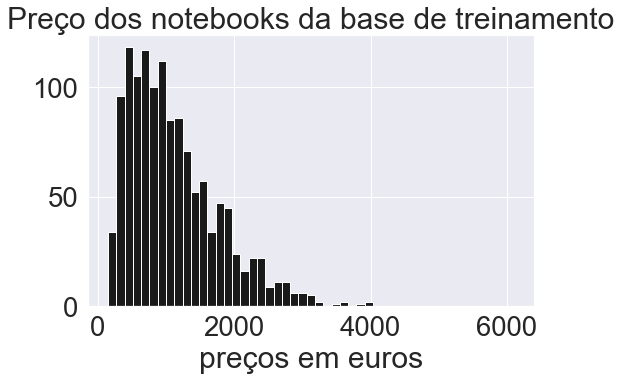

In [36]:
faixas = np.linspace(150, 6100, 50)

plt.figure(figsize=(8,5))

plt.subplot(111)
plt.hist(dados['Price_euros'], bins = faixas, edgecolor='white', color='k')
plt.xlabel('preços em euros')
plt.title("Preço dos notebooks da base de treinamento")
plt.show()

Apesar de ter muitos "outliers" no gráfico, manteremos a maioria para a análise, pois era esperado que haja uma grande diferença de preço entre diferentes categorias de notebooks e como estamos analisando várias categorias é provável que os preços mais altos sejam de uma categoria específica. Dessa forma a qualidade da previsão do código seria afetada para determinadas categorias caso todos "outliers" não fossem desconsiderados no treinamento.


Entretanto, limitaremos o preço máximo a 4000 euros para melhorar a qualidade geral da previsão, pois é um valor que engloba até as categorias com maiores preços.

In [31]:
dados = dados.loc[dados['Price_euros'] <= 4000, :]

### 2.2 Comparação das variáveis

In [32]:
precos_por_marca = dados.sort_values(['Company'])
precos_por_marca.head()

,Company,TypeName,Processor,Inches,Ram,Memory,Gpu,Price_euros
651,Acer,Gaming,Intel Core i5,15.6,8GB,1TB HDD,Nvidia GeForce GTX 1050,709.0
78,Acer,Notebook,Intel Core i3,15.6,4GB,1TB HDD,Nvidia GeForce MX130,530.0
324,Acer,Notebook,AMD,15.6,8GB,256GB SSD,AMD Radeon RX 540,659.0
326,Acer,Notebook,Intel Core i5,15.6,6GB,1TB HDD,Intel HD Graphics 620,549.0
371,Acer,Notebook,AMD,15.6,4GB,128GB SSD,AMD Radeon R5,426.0


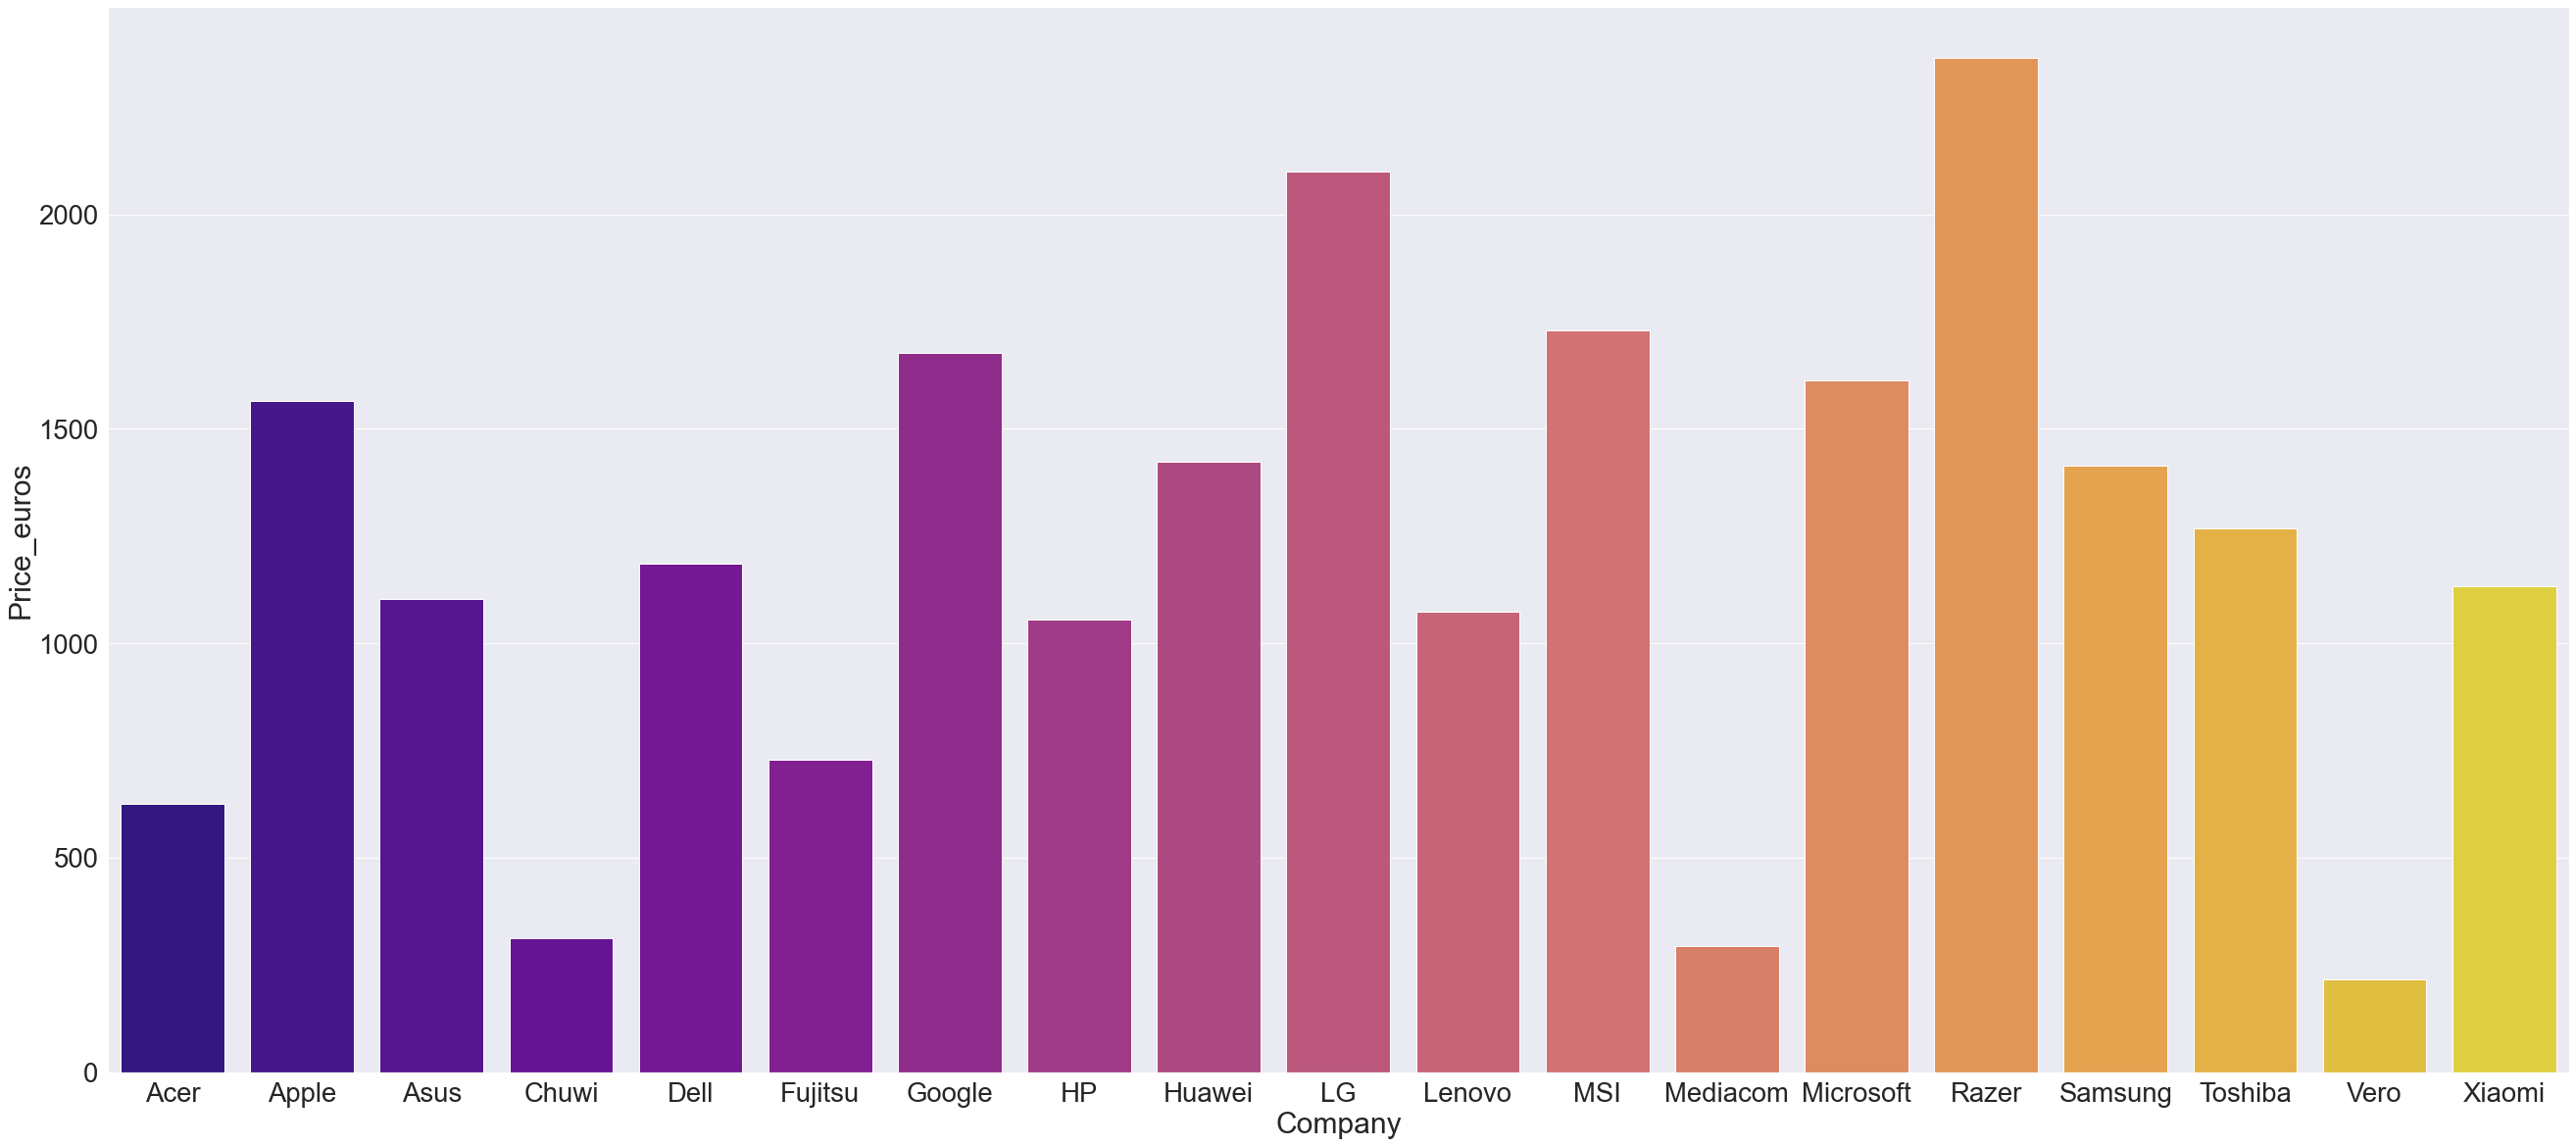

In [33]:
precos_por_marca = dados.groupby('Company')['Price_euros'].mean().reset_index()

plt.figure(figsize = (45,20))
sns.set(font_scale = 2.5)
ax = sns.barplot(x='Company', y='Price_euros', data= precos_por_marca,order = precos_por_marca['Company'], palette = 'plasma')

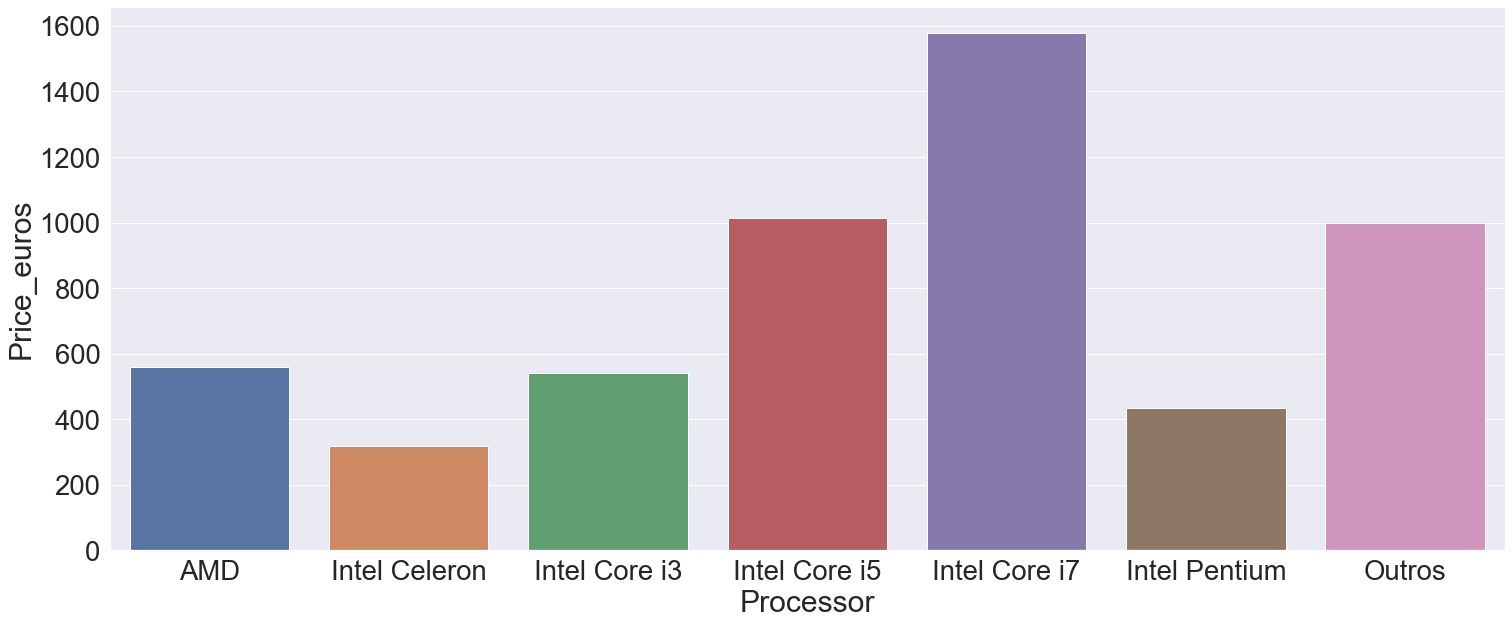

In [34]:
precos_por_processador = dados.groupby('Processor')['Price_euros'].mean().reset_index()

plt.figure(figsize = (25,10))
sns.set(font_scale = 2.5)
ax = sns.barplot(x='Processor', y='Price_euros', data= precos_por_processador,order = precos_por_processador['Processor'])

In [35]:
precos_por_processador

,Processor,Price_euros
0,AMD,560.638871
1,Intel Celeron,319.328523
2,Intel Core i3,541.625956
3,Intel Core i5,1015.015248
4,Intel Core i7,1579.766838
5,Intel Pentium,435.540000
6,Outros,998.893143


[Voltar para o sumário](#sumario)

___
<div id='prediction'></div>

## 3. Modelos de Predição

Descrever e justificar pelo menos **DUAS** técnicas de predição.

### Criando base de teste e treinamento 

A base da dados deve ser seraparada entre uma parte qual será responsável por ensinar o algoritmo a fazer as predições, e em outra na qual o robô será testato, para verificar sua eficiência. 

In [39]:
features = ['Company', 'TypeName', 'Processor', 'Inches', 'Ram', 'Memory', 'Gpu']
X = dados.loc[:, features]
y = dados.loc[:, ['Price_euros']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .60)

X_train.head(3)

,Company,TypeName,Processor,Inches,Ram,Memory,Gpu
145,Asus,Ultrabook,Intel Core i7,14.0,8GB,256GB SSD,Intel UHD Graphics 620
319,Acer,Notebook,Intel Pentium,11.6,4GB,128GB Flash Storage,Intel HD Graphics 405
648,Toshiba,Notebook,Intel Core i5,13.3,8GB,256GB SSD,Intel HD Graphics 520


In [40]:
X_test.head(3)

,Company,TypeName,Processor,Inches,Ram,Memory,Gpu
580,Mediacom,Notebook,Intel Celeron,14.0,4GB,32GB SSD,Intel HD Graphics 500
1017,Lenovo,Notebook,Intel Core i7,17.3,16GB,512GB SSD,Nvidia Quadro 3000M
762,Google,Ultrabook,Intel Core i5,12.3,8GB,256GB SSD,Intel HD Graphics 615


[Voltar para o sumário](#sumario)

___
<div id='validation'></div>

## 4. Processo e Estatísticas de validação

Calcular medidas que informam a performance de cada modelo ajustado. Para cada um:

* Dividir a base de dados em **Treinamento** e **Teste**. Usar **Treinamento** para estimar cada modelo.

* Estudar medidas que validam os modelos.

    Exemplos:

    * <a href='https://help.salesforce.com/s/articleView?id=sf.bi_edd_model_metrics_cross_validation_measure.htm&type=5'>Cross Validation Tab for Numeric Use Cases</a>

    * <a href='https://paulovasconcellos.com.br/como-saber-se-seu-modelo-de-machine-learning-está-funcionando-mesmo-a5892f6468b'>Como saber se seu modelo de Machine Learning está funcionando mesmo</a>

    * <a href='https://ensinandomaquinasblog.wordpress.com/2017/12/15/modelos-preditivos-de-notas-de-redacao-do-enem-2015/'>Modelos Preditivos de Notas de Redação do ENEM 2015</a>

* Discutir sobre overfitting e underfitting (<a href='https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/'>link</a>)

* **Extra**: Faça o processo de Validação Cruzada utilizando também 10 ciclos e calcule a performance média e desvio padrão das duas medidas R2 e RMS tanto para a parte treinamento como para a parte teste. Discuta com riqueza de detalhes.

[Voltar para o sumário](#sumario)

___
<div id='conclusion'></div>

## 5. Conclusão

[Voltar para o sumário](#sumario)

___
<div id='ref'></div>

## 6. Referências Bibliográficas

- Banco de dados:
https://www.kaggle.com/datasets/muhammetvarl/laptop-price

[Voltar para o sumário](#sumario)